# 🧰 Setup

In [120]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.data import imread

## 🛣️ Data paths

In [121]:
PATH = './'
TRAIN = '../input/airbus-ship-detection/train_v2'
TEST = '../input/airbus-ship-detection/test_v2/'
SEGMENTATION = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

In [122]:
traincsv = pd.read_csv(SEGMENTATION)

# 🛠️ Utilities

In [123]:
def encodedpixels2rle(encodedpixels):
    if isinstance(encodedpixels, str):
        return np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    return np.array([])


def rle2mask(rle, shape=(768, 768)):
    """
    rle: 2D numpy array with rows of form [start, run-length]
    shape: (rows, cols) the shape of the referenced image
    """
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    run_ranges = [(start - 1, start + length - 1) for (start, length) in rle]
    for a, b in run_ranges:
        mask[a:b] = 1
    return mask.reshape(shape).T


def get_train_combined_masks(imgid):
    return(rle2mask(encodedpixels2rle(' '.join(
        traincsv[traincsv.ImageId == imgid]['EncodedPixels'].fillna('').astype(str)))))


# ✂️ Segmentation training data

In [124]:
print(traincsv.head())
traincsv.describe()

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,6c06acaa5.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


## 📈 Image statistics

In [125]:
print("Total inferrences in the train set: " , traincsv.shape[0])

id_images = traincsv.ImageId.unique()
id_images_noships = traincsv[traincsv.EncodedPixels.isna()].ImageId.unique()
id_images_ships = traincsv[traincsv.EncodedPixels.notna()].ImageId.unique()

n_images = id_images.shape[0]
n_images_noships = id_images_noships.shape[0]
n_images_ships = id_images_ships.shape[0]

print("Total no. of images: ", n_images)
print("Images without ships: ", n_images_noships)
print("Images with ships: ", n_images_ships)

Total inferrences in the train set:  231723
Total no. of images:  192556
Images without ships:  150000
Images with ships:  42556


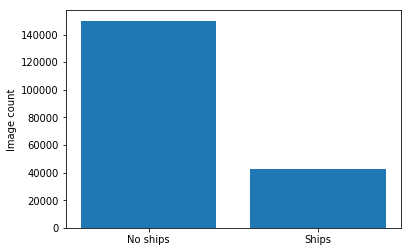

In [126]:
plt.bar(['No ships', 'Ships'], [n_images_noships, n_images_ships]);
plt.ylabel('Image count');

In [127]:
id_images_obj = traincsv.dropna().groupby('ImageId').count()
id_images_obj.rename({'EncodedPixels': 'ObjCount'}, axis='columns', inplace=True)

print("Objects: ", id_images_obj.ObjCount.sum())
id_images_obj.describe()

Objects:  81723


,ObjCount
count,42556.000000
mean,1.920364
std,1.906073
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


# 🖼️ Images with their masks

## ❌ Images without ships 


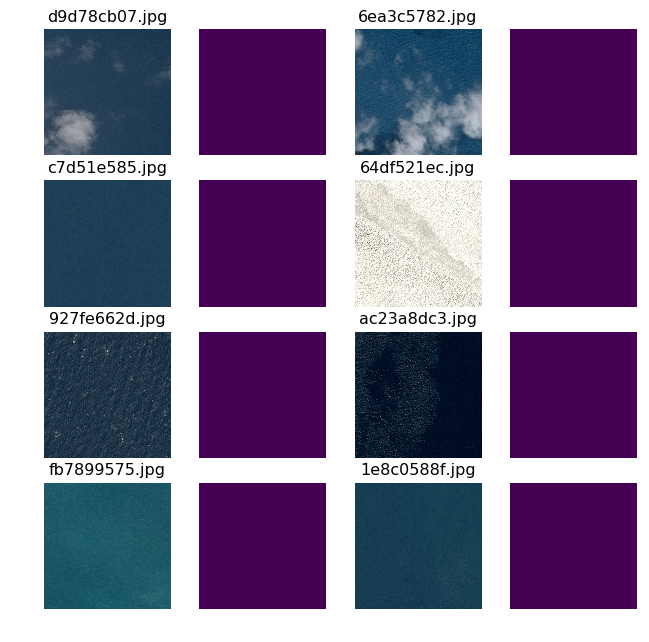

In [128]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)
ax = ax.reshape(-1)
for a in ax: 
    a.axis('off')

# display
for i, imgid in enumerate(np.random.choice(id_images_noships, 8, replace=False)):
    msk = get_train_combined_masks(imgid)
    ax[2*i].imshow(read_train_image(imgid))
    ax[2*i].set_title(imgid)
    ax[2*i+1].imshow(msk)

## 🚢 Images with ships

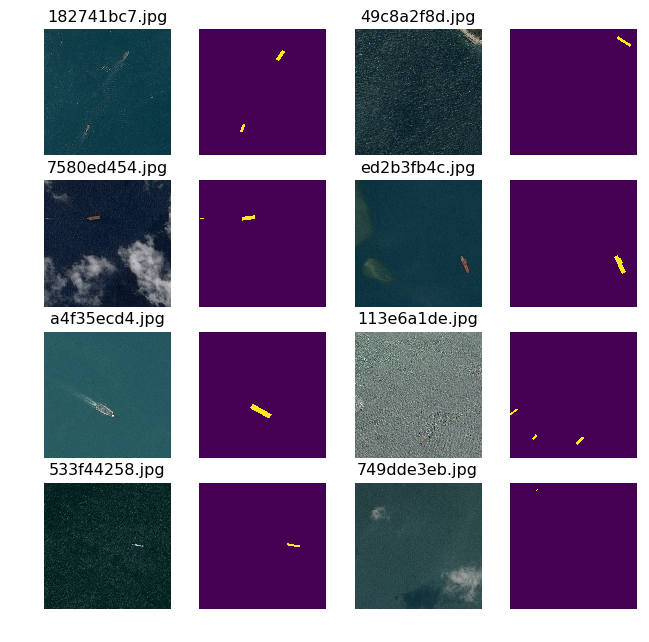

In [129]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)
ax = ax.reshape(-1)
for a in ax: 
    a.axis('off')

# display
for i, imgid in enumerate(np.random.choice(id_images_ships, 8, replace=False)):
    msk = get_train_combined_masks(imgid)
    ax[2*i].imshow(read_train_image(imgid))
    ax[2*i].set_title(imgid)
    ax[2*i+1].imshow(msk)